In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import datetime
import copy
import time
import wandb
import pickle as pkl

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.fit import plot_histogram, plot_all_histograms, plot_mean_variance, plot_scatter, plot_kl_divergence, plot_heatmap_distribution_sigmas, plot_all_params, plot_all_losses, plot_all_buckets, plot_variation_with_iterations
import yaml

In [3]:
predictions_dict = {}

In [4]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

In [5]:
predictions_dict.keys()

dict_keys([])

In [6]:
config_filenames = ['experiments/seirhd.yaml', 'experiments/seir_pu.yaml']
model_params = {
        'SEIRHD Free': [ 'lockdown_R0', 'T_inc', 'T_inf', 'T_inf', 'T_recov', 'T_recov_fatal', 'P_fatal', 'E_hosp_ratio', 'I_hosp_ratio'],
        'SEIR_PU': [ 'T_inc', 'T_inf_U', 'T_recov', 'T_recov_fatal', 'beta', 'd', 'P_fatal', 'I_hosp_ratio', 'E_hosp_ratio','Pu_pop_ratio'],
    }
model_types = {'SEIRHD Free' : 'SEIRHD', 'SEIR Cons' : 'SEIRHD', 'SEIR_Undetected':'SEIR_Undetected','SEIR_PU':'SEIR_PU','SEIR_PU_Testing':'SEIR_PU_Testing'}
model_names = list(model_params.keys())
configs = [read_config(config_filename) for config_filename in config_filenames]
location_tuples = {
    'MUMBAI' : ('Maharashtra', 'Mumbai', None, None),
    'RANCHI' : ('Jharkhand', 'Ranchi', None, None),
}

MUMBAI <class 'models.seir.seirhd.SEIRHD'>
Performing m1 fit ..
pulling from source
198 198
Smoothing 7358 recovered between 2020-05-28 and 2020-04-26 (32) days in a weighted-mag manner
Smoothing 3139 recovered between 2020-06-14 and 2020-04-26 (49) days in a weighted-mag manner
Smoothing 917 deceased between 2020-06-15 and 2020-04-26 (50) days in a weighted-mag manner
Smoothing 2432 recovered between 2020-06-23 and 2020-06-15 (8) days in a weighted-mag manner
Smoothing 2141 recovered between 2020-06-24 and 2020-06-15 (9) days in a weighted-mag manner
Smoothing 5900 recovered between 2020-07-01 and 2020-05-28 (34) days in a weighted-mag manner

splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 165                 | 166                 | 167                 | 168                 | 169                 |
|-------------+---------------------+---------------

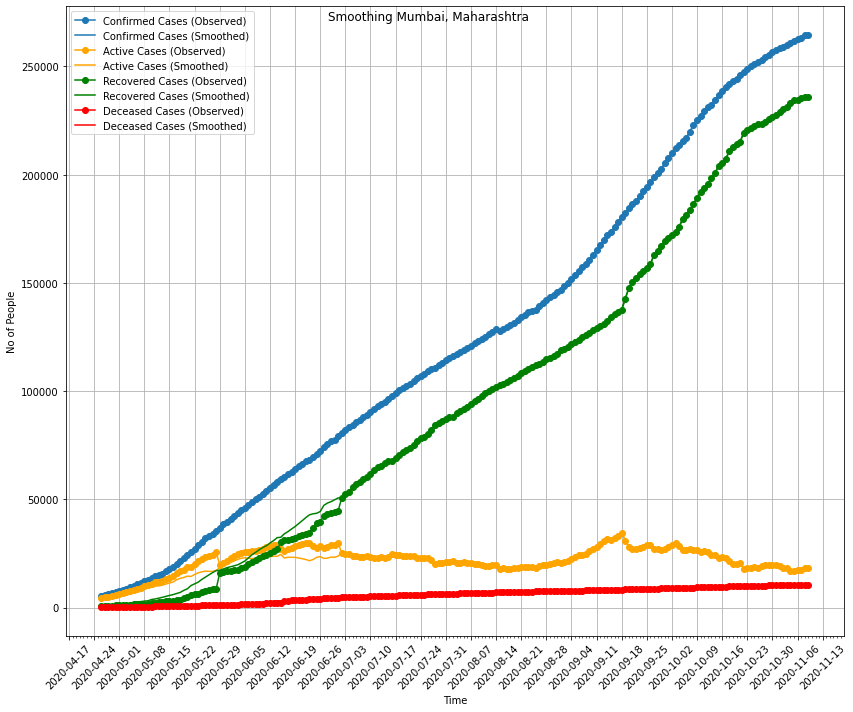

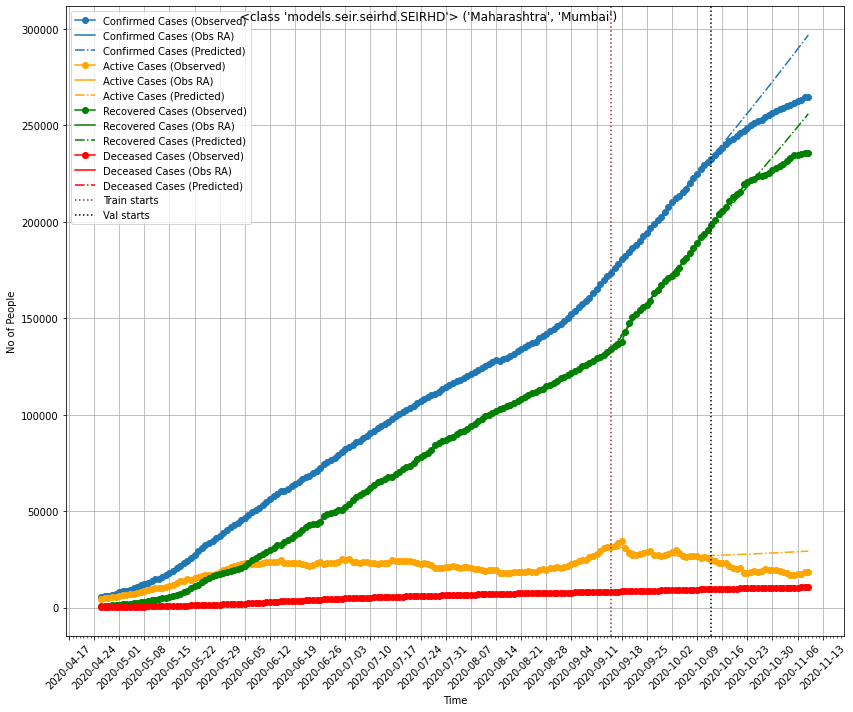

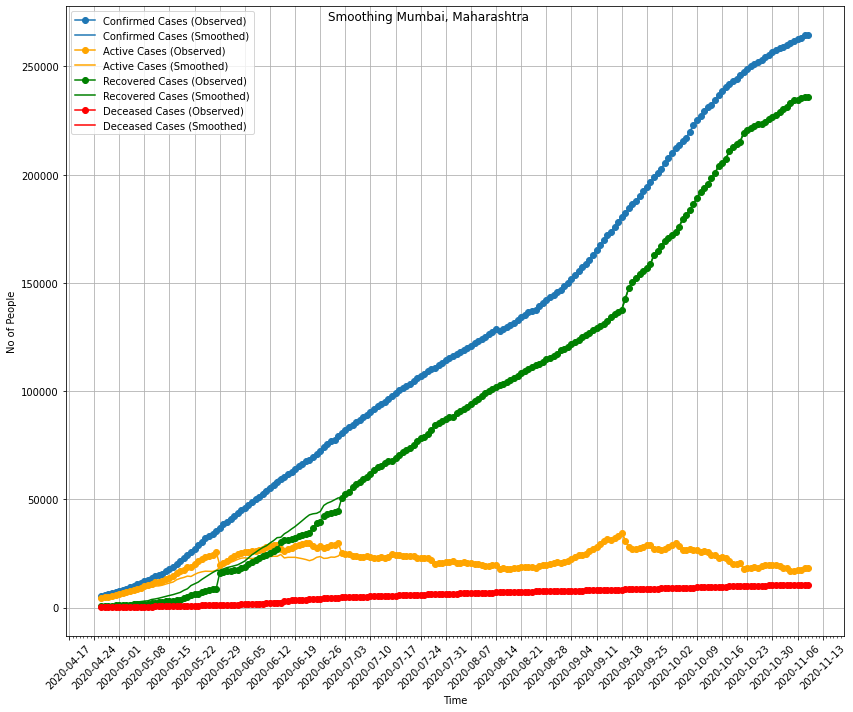

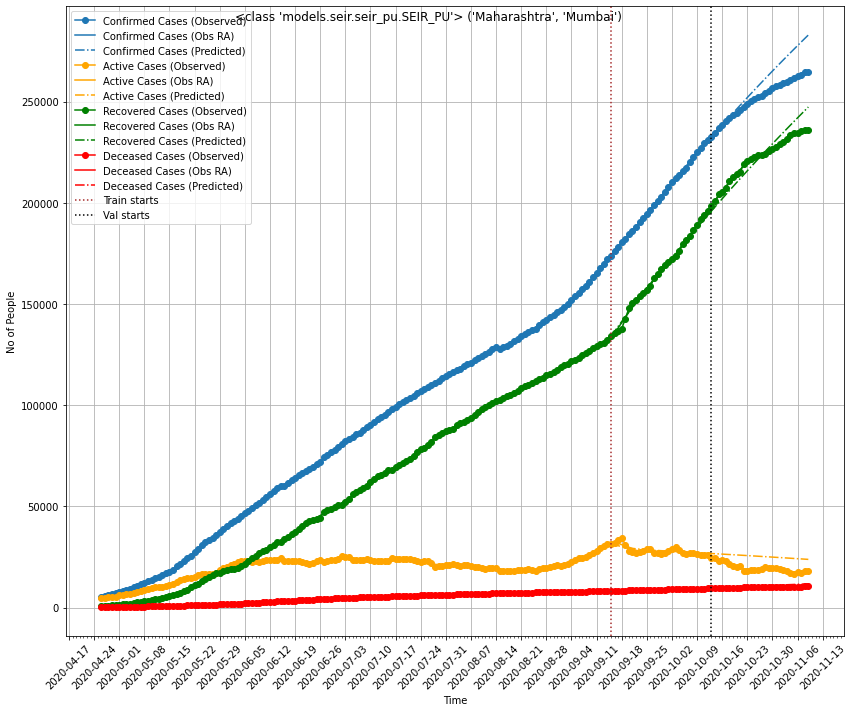

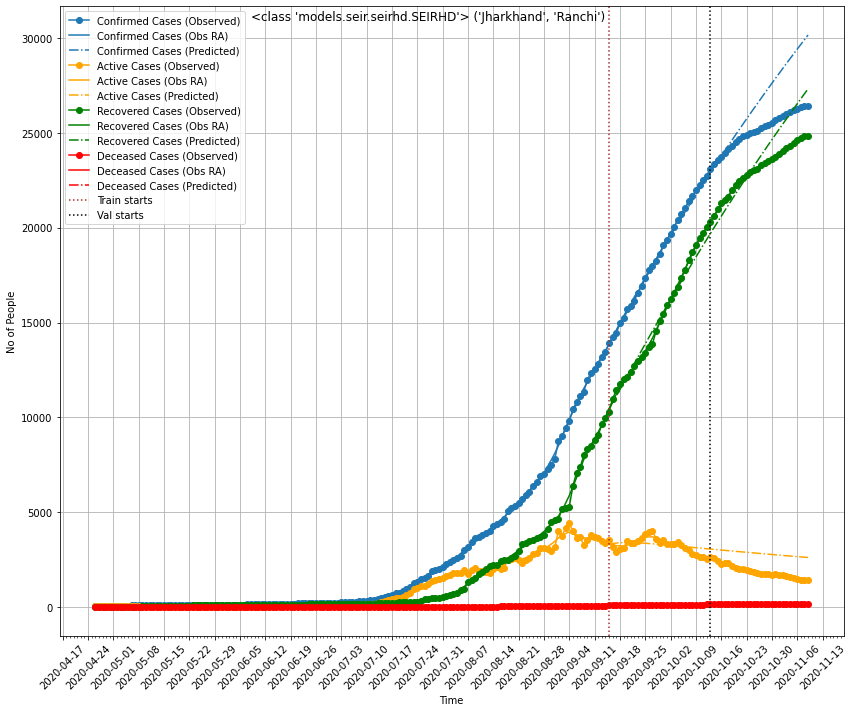

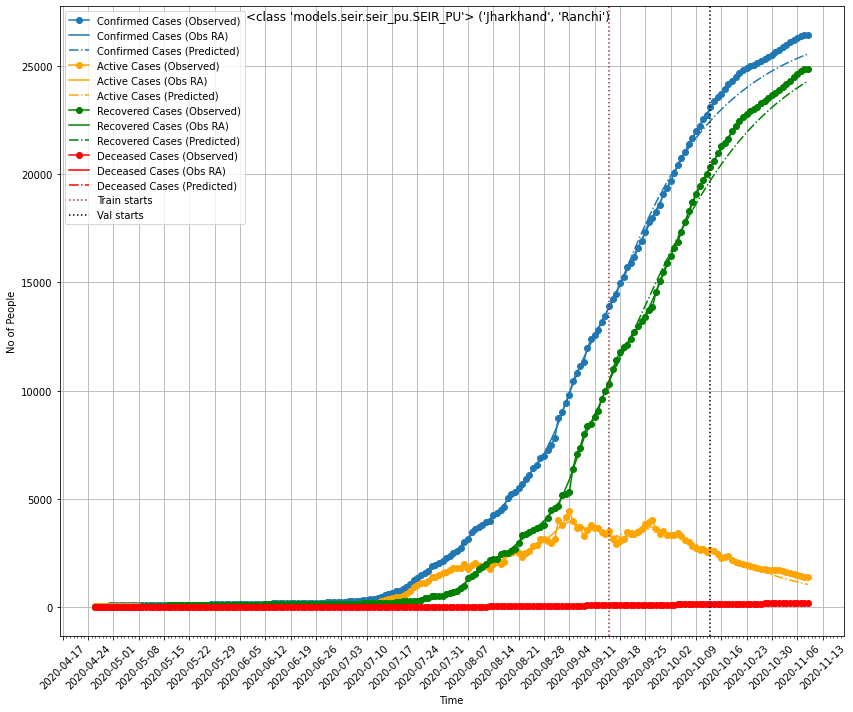

In [7]:
num_rep_trials = 1
for tag, loc in location_tuples.items():
    predictions_dict[tag] = {}
    for j, config in enumerate(configs):
        print(tag,config['fitting']['model'])
        predictions_dict[tag][model_names[j]] = {}
        config_params = copy.deepcopy(config['fitting'])
        config_params['data']['dataloading_params']['state'] = loc[0]
        config_params['data']['dataloading_params']['district'] = loc[1]
        config_params['split']['start_date'] = loc[2]
        config_params['split']['end_date'] = loc[3]
        if loc[1] != 'Mumbai':
            config_params['data']['smooth_jump'] = False
        for k in range(num_rep_trials):
            predictions_dict[tag][model_names[j]][f'm{k}'] = single_fitting_cycle(**config_params) 

In [8]:
save_dir = '../../misc/predictions/loss_v_trials/'    
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for tag, tag_dict in predictions_dict.items():
    with open(os.path.join(save_dir, tag + ".pickle"), 'wb') as handle:
        pkl.dump(tag_dict, handle)

### Use the pickle file to read the predicitons_dict

In [9]:
save_dir = '../../misc/predictions/loss_v_trials/'    
predictions_dict_complete = {}
files_to_read = []
files = [i+'.pickle' for i in files_to_read if i+'.pickle' in os.listdir(save_dir)]
if len(files) == 0:
    files = os.listdir(save_dir)
for file_name in files:
    with open(os.path.join(save_dir, file_name), 'rb') as handle:
        predictions_dict_complete[file_name.split('.')[0]] = pkl.load(handle)

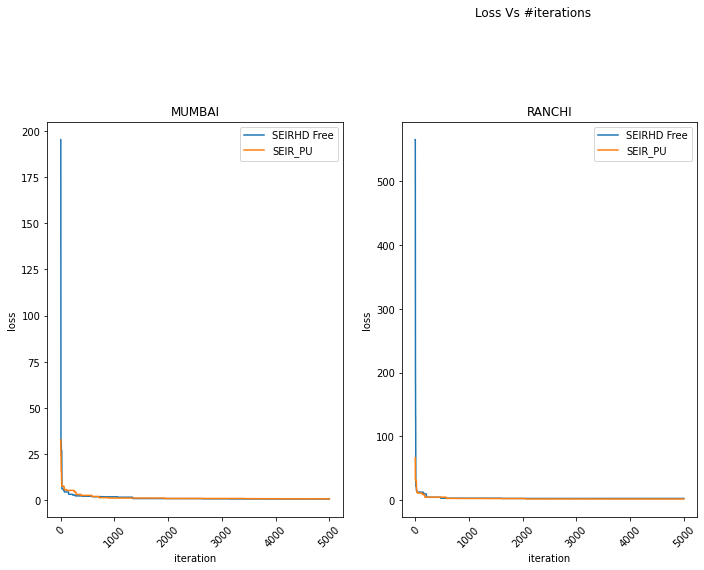

In [10]:
plot_variation_with_iterations(predictions_dict_complete, compare='model', start_iter=100)

In [ ]:
wandb.init(project="covid-modelling")
wandb.run.name = "degeneracy-exps-location"+wandb.run.name

In [ ]:
plot_all_params(predictions_dict, model_params, method='ensemble_combined')

In [ ]:
which_compartments = {model_names[i]: config['fitting']['loss']['loss_compartments'] for i, config in enumerate(configs)}
plot_all_losses(predictions_dict, which_losses=['train', 'val'], which_compartments=which_compartments)

In [ ]:
plot_all_buckets(predictions_dict, which_buckets=['S', 'I', 'E', 'I_U'], compare='model', model_types=model_types)